In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import os, torch, random, shutil, numpy as np, pandas as pd
from glob import glob; from PIL import Image
Image.MAX_IMAGE_PIXELS = None 
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
import PIL
torch.manual_seed(2024)

In [16]:
class CustomDataset(Dataset):
    def __init__(self, im_paths, cls_names, transformations=None):
        self.im_paths = im_paths
        self.transformations = transformations
        self.cls_names = cls_names
            
    def get_cls_name(self, path): 
        # Gets the folder name (class) from the path
        return os.path.dirname(path).split("/")[-1]
    
    def __len__(self): 
        return len(self.im_paths)

    def get_pos_neg_im_paths(self, qry_label):
        # We need to search within the current split for pairs
        pos_im_paths = [p for p in self.im_paths if qry_label == self.get_cls_name(p)]
        neg_im_paths = [p for p in self.im_paths if qry_label != self.get_cls_name(p)]
        
        pos_path = random.choice(pos_im_paths)
        neg_path = random.choice(neg_im_paths)
        
        return pos_path, neg_path

    def __getitem__(self, idx):
        try:
            im_path = self.im_paths[idx]
            
            # --- Helper to handle transparency and avoid Palette Warnings ---
            def safe_open(path):
                with Image.open(path) as img:
                    # If image is palette (P) or has alpha channel (RGBA), 
                    # convert to RGBA then paste onto a white background
                    if img.mode in ("RGBA", "P"):
                        img = img.convert("RGBA")
                        new_img = Image.new("RGB", img.size, (255, 255, 255))
                        new_img.paste(img, mask=img.split()[3]) # use alpha channel as mask
                        return new_img
                    return img.convert("RGB")

            # Load images using the safe helper
            qry_im = safe_open(im_path)
            qry_label = self.get_cls_name(im_path)

            pos_im_path, neg_im_path = self.get_pos_neg_im_paths(qry_label)
            pos_im = safe_open(pos_im_path)
            neg_im = safe_open(neg_im_path)

            # Get labels
            qry_gt = self.cls_names[qry_label]
            neg_label = self.get_cls_name(neg_im_path)
            neg_gt = self.cls_names[neg_label]

            # Transformations
            if self.transformations:
                qry_im = self.transformations(qry_im)
                pos_im = self.transformations(pos_im)
                neg_im = self.transformations(neg_im)

            return {
                "qry_im": qry_im, 
                "qry_gt": qry_gt, 
                "pos_im": pos_im, 
                "neg_im": neg_im,
                "neg_gt": neg_gt
            }
            
        except (Exception) as e:
            # If any error occurs (corrupt file, etc.), try a different random index
            return self.__getitem__(random.randint(0, len(self.im_paths)-1))

In [17]:
class CustomDataset(Dataset):
    def __init__(self, im_paths, cls_names, transformations=None):
        self.im_paths = im_paths
        self.transformations = transformations
        self.cls_names = cls_names
        
        # --- OPTIMIZATION: Pre-calculate paths for each class ---
        # This prevents searching the entire list every time __getitem__ is called
        self.class_to_paths = {}
        for path in self.im_paths:
            cls = self.get_cls_name(path)
            if cls not in self.class_to_paths:
                self.class_to_paths[cls] = []
            self.class_to_paths[cls].append(path)
            
    def get_cls_name(self, path): 
        return os.path.dirname(path).split("/")[-1]
    
    def __len__(self): 
        return len(self.im_paths)

    def get_pos_neg_im_paths(self, qry_label):
        # FAST LOOKUP: Use the pre-calculated dictionary
        pos_im_paths = self.class_to_paths[qry_label]
        
        # Pick a random class that is NOT the query label
        all_classes = list(self.class_to_paths.keys())
        neg_label = random.choice(all_classes)
        while neg_label == qry_label:
            neg_label = random.choice(all_classes)
            
        neg_im_paths = self.class_to_paths[neg_label]
        
        pos_path = random.choice(pos_im_paths)
        neg_path = random.choice(neg_im_paths)
        
        return pos_path, neg_path

    def __getitem__(self, idx):
        # (Keep your existing safe_open and logic here, it is fine)
        try:
            im_path = self.im_paths[idx]
            
            def safe_open(path):
                with Image.open(path) as img:
                    if img.mode in ("RGBA", "P"):
                        img = img.convert("RGBA")
                        new_img = Image.new("RGB", img.size, (255, 255, 255))
                        new_img.paste(img, mask=img.split()[3])
                        return new_img
                    return img.convert("RGB")

            qry_im = safe_open(im_path)
            qry_label = self.get_cls_name(im_path)

            pos_im_path, neg_im_path = self.get_pos_neg_im_paths(qry_label)
            pos_im = safe_open(pos_im_path)
            neg_im = safe_open(neg_im_path)

            qry_gt = self.cls_names[qry_label]
            neg_label = self.get_cls_name(neg_im_path)
            neg_gt = self.cls_names[neg_label]

            if self.transformations:
                qry_im = self.transformations(qry_im)
                pos_im = self.transformations(pos_im)
                neg_im = self.transformations(neg_im)

            return {
                "qry_im": qry_im, "qry_gt": qry_gt, 
                "pos_im": pos_im, "neg_im": neg_im, "neg_gt": neg_gt
            }
            
        except (Exception) as e:
            return self.__getitem__(random.randint(0, len(self.im_paths)-1))

In [18]:
from collections import Counter
from sklearn.model_selection import train_test_split

def get_dls(root, transformations, bs, split=[0.9, 0.05, 0.05], ns=4):
    # 1. Get all image paths
    all_paths = glob(f"{root}/*/*.png")
    
    # 2. Extract unique classes and map them to IDs
    # Mapping folder names to integers
    unique_classes = sorted(list(set([os.path.dirname(p).split("/")[-1] for p in all_paths])))
    cls_names = {cls: i for i, cls in enumerate(unique_classes)}
    
    # 3. Perform the split
    train_paths, remain_paths = train_test_split(all_paths, train_size=split[0], random_state=2024, shuffle=True)
    
    # Split the remainder into Val and Test
    val_ratio = split[1] / (split[1] + split[2])
    val_paths, ts_paths = train_test_split(remain_paths, train_size=val_ratio, random_state=2024, shuffle=True)

    # 4. Calculate class counts for the return variable 'cls_counts'
    # This counts how many images of each Pokemon are in each split
    tr_counts = Counter([os.path.dirname(p).split("/")[-1] for p in train_paths])
    vl_counts = Counter([os.path.dirname(p).split("/")[-1] for p in val_paths])
    ts_counts = Counter([os.path.dirname(p).split("/")[-1] for p in ts_paths])
    
    # Combine counts into the list format your code expects
    combined_counts = [dict(tr_counts), dict(vl_counts), dict(ts_counts)]

    # 5. Create Dataset Objects
    tr_ds = CustomDataset(train_paths, cls_names, transformations)
    vl_ds = CustomDataset(val_paths, cls_names, transformations)
    ts_ds = CustomDataset(ts_paths, cls_names, transformations)

    # 6. Create DataLoaders
    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns, pin_memory = True, drop_last = True)
    vl_dl = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns, pin_memory = True, drop_last = True)
    ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns)
    
    # Now returns 5 values as expected
    return tr_dl, vl_dl, ts_dl, cls_names, combined_counts

In [19]:
# def get_dls(root, transformations, bs, split=[0.9, 0.05, 0.05], ns=4):
#     all_paths = []
    
#     # 1. Iterate over every class folder individually
#     class_folders = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
    
#     print(f"Processing {len(class_folders)} classes...")
    
#     for class_name in class_folders:
#         class_dir = os.path.join(root, class_name)
        
#         # Get images for THIS class only
    #     images = glob(f"{class_dir}/*.png")
    #     sample_size = max(1, int(len(images) * 0.10))
        
    #     if len(images) > 0:
    #         # Randomly sample the 10%
    #         sampled_imgs = random.sample(images, min(len(images), sample_size))
    #         all_paths.extend(sampled_imgs)

    # print(f"DEBUG: Selected {len(all_paths)} images (10% from every Pokemon)")
    
    # # 2. Shuffle the final combined list so classes aren't grouped sequentially
    # random.seed(2024)
    # random.shuffle(all_paths)

    # # 3. Extract unique classes and map them to IDs
    # unique_classes = sorted(list(set([os.path.dirname(p).split("/")[-1] for p in all_paths])))
    # cls_names = {cls: i for i, cls in enumerate(unique_classes)}
    
    # # 4. Perform the split
    # train_paths, remain_paths = train_test_split(all_paths, train_size=split[0], random_state=2024, shuffle=True)
    
    # val_ratio = split[1] / (split[1] + split[2])
    # val_paths, ts_paths = train_test_split(remain_paths, train_size=val_ratio, random_state=2024, shuffle=True)

    # # 5. Calculate class counts
    # tr_counts = Counter([os.path.dirname(p).split("/")[-1] for p in train_paths])
    # vl_counts = Counter([os.path.dirname(p).split("/")[-1] for p in val_paths])
    # ts_counts = Counter([os.path.dirname(p).split("/")[-1] for p in ts_paths])
    
    # combined_counts = [dict(tr_counts), dict(vl_counts), dict(ts_counts)]

    # # 6. Create Dataset Objects
    # tr_ds = CustomDataset(train_paths, cls_names, transformations)
    # vl_ds = CustomDataset(val_paths, cls_names, transformations)
    # ts_ds = CustomDataset(ts_paths, cls_names, transformations)

    # # 7. Create DataLoaders
    # tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns, pin_memory = True, drop_last = True)
    # vl_dl = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns, pin_memory = True, drop_last = True)
    # ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns)
    
    # return tr_dl, vl_dl, ts_dl, cls_names, combined_counts

In [20]:
root = "/kaggle/input/1282-pokemon-139542-images-updated-pokedex-dataset/Pokemon Labelled Classification Images"
mean, std, size, bs = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224, 24
tfs = T.Compose([T.ToTensor(), T.Resize(size = (size, size), antialias = False), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes, cls_counts = get_dls(root = root, transformations = tfs, bs = bs)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

4910
272
6547
{'abomasnow': 0, 'abra': 1, 'absol': 2, 'accelgor': 3, 'aegislash': 4, 'aerodactyl': 5, 'aggron': 6, 'aipom': 7, 'alakazam': 8, 'alcremie': 9, 'alomomola': 10, 'altaria': 11, 'amaura': 12, 'ambipom': 13, 'amoonguss': 14, 'ampharos': 15, 'annihilape': 16, 'anorith': 17, 'appletun': 18, 'applin': 19, 'araquanid': 20, 'arbok': 21, 'arboliva': 22, 'arcanine': 23, 'arceus': 24, 'archaludon': 25, 'archen': 26, 'archeops': 27, 'arctibax': 28, 'arctovish': 29, 'arctozolt': 30, 'ariados': 31, 'armaldo': 32, 'armarouge': 33, 'aromatisse': 34, 'aron': 35, 'arrokuda': 36, 'articuno': 37, 'audino': 38, 'aurorus': 39, 'avalugg': 40, 'axew': 41, 'azelf': 42, 'azumarill': 43, 'azurill': 44, 'bagon': 45, 'baltoy': 46, 'banette': 47, 'barbaracle': 48, 'barboach': 49, 'barraskewda': 50, 'basculegion': 51, 'basculin': 52, 'bastiodon': 53, 'baxcalibur': 54, 'bayleef': 55, 'beartic': 56, 'beautifly': 57, 'beedrill': 58, 'beheeyem': 59, 'beldum': 60, 'bellibolt': 61, 'bellossom': 62, 'bellsprou

Data analysis is in process...



/tmp/ipykernel_55/1961903193.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names)


Data analysis is in process...



/tmp/ipykernel_55/1961903193.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names)


Data analysis is in process...



/tmp/ipykernel_55/1961903193.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names)


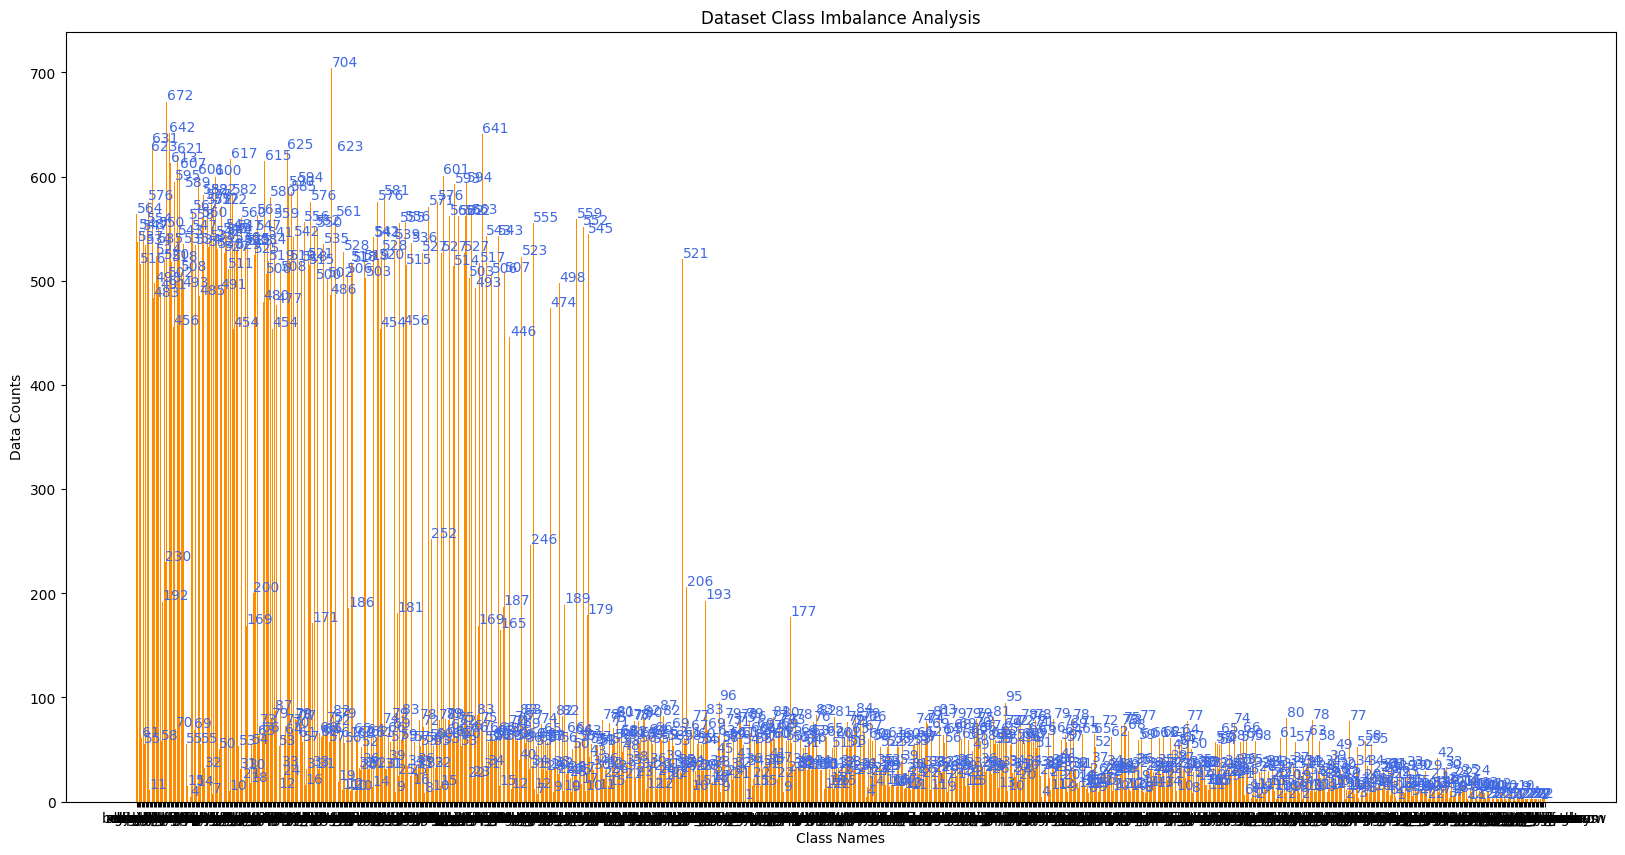

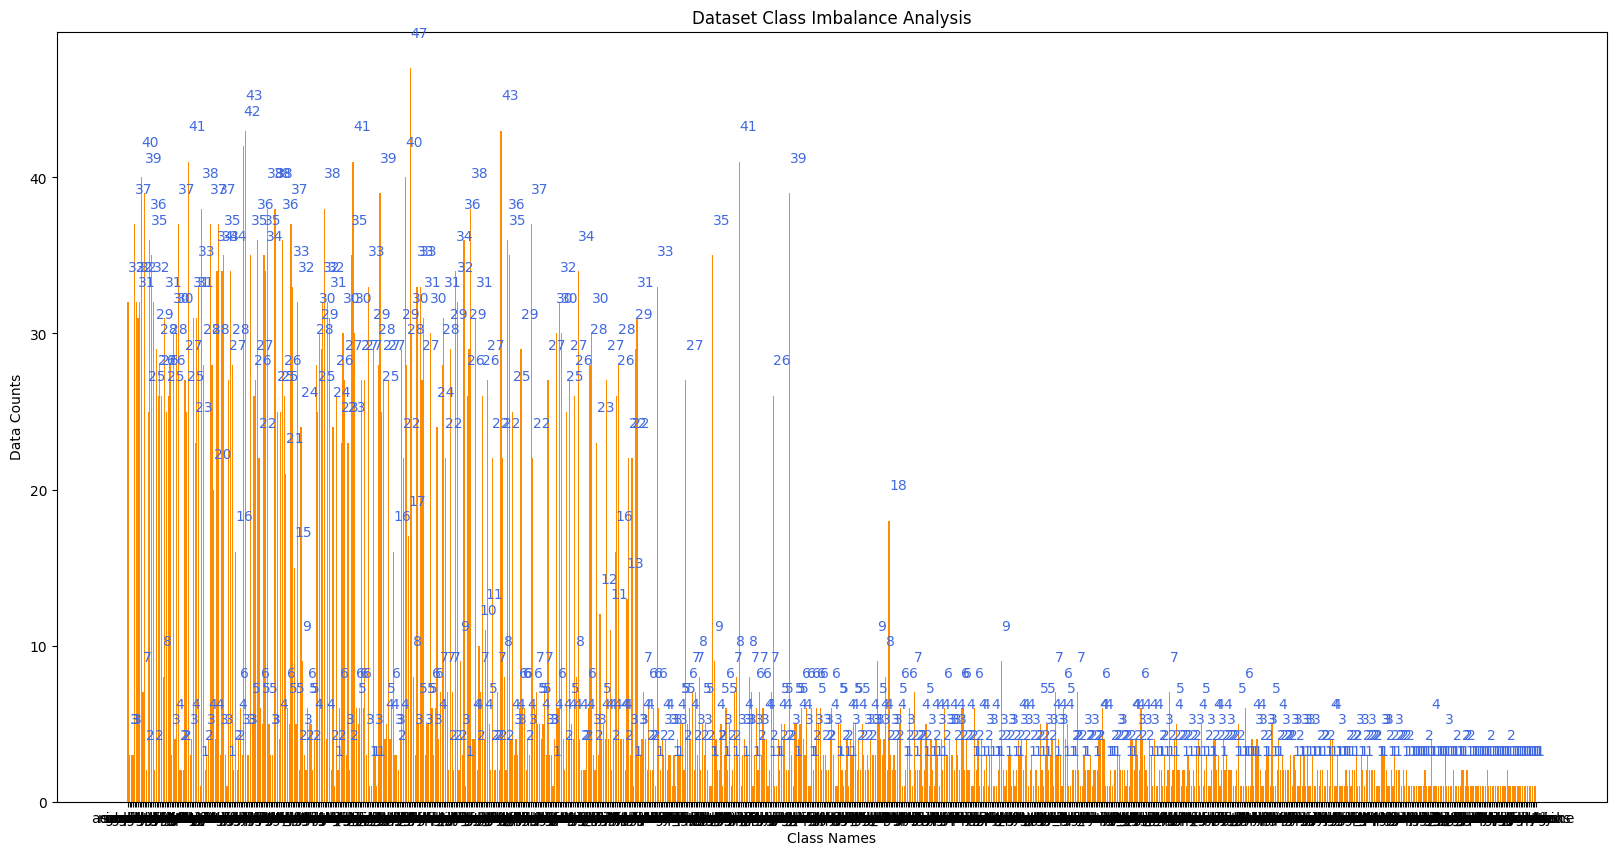

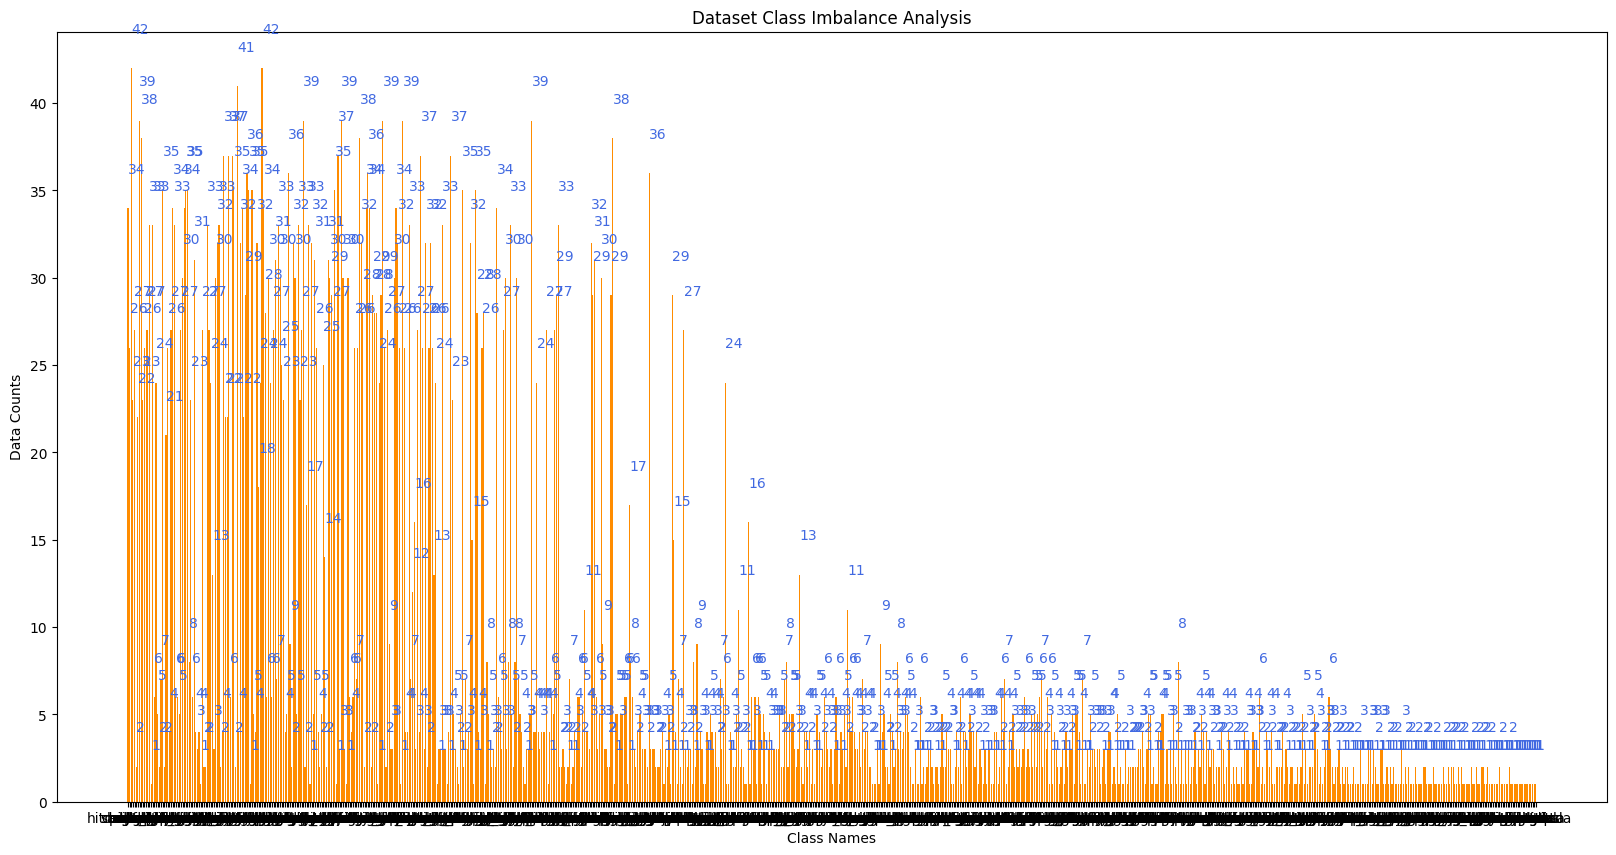

In [21]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms as T

class Visualization:

    def __init__(self, vis_datas, n_ims, rows, cmap = None, cls_names = None, cls_counts = None, t_type = "rgb"):

        self.n_ims, self.rows = n_ims, rows
        self.t_type, self.cmap,  = t_type, cmap
        self.cls_names = cls_names
        
        data_names = ["train", "val", "test"]
        self.vis_datas = {data_names[i]: vis_datas[i] for i in range(len(vis_datas))} 
        if isinstance(cls_counts, list): self.analysis_datas = {data_names[i]: cls_counts[i] for i in range(len(cls_counts))} 
        else: self.analysis_datas = {"all": cls_counts}

    def tn2np(self, t):
        
        gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
        rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
        
        invTrans = gray_tfs if self.t_type == "gray" else rgb_tfs 
        
        return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if self.t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

    def plot(self, rows, cols, count, im, title = "Original Image"):
    
        plt.subplot(rows, cols, count)
        plt.imshow(self.tn2np(im))
        plt.axis("off"); plt.title(title)
        
        return count + 1

    def vis(self, data, save_name):

        print(f"{save_name.upper()} Data Visualization is in process...\n")
        assert self.cmap in ["rgb", "gray"], "Please choose rgb or gray cmap"
        if self.cmap == "rgb": cmap = "viridis"
        cols = self.n_ims // self.rows; count = 1
        
        plt.figure(figsize = (25, 20))
                
        indices = [np.random.randint(low = 0, high = len(data) - 1) for _ in range(self.n_ims)]

        for idx, index in enumerate(indices):
        
            if count == self.n_ims + 1: break
            
            meta_data = data[index]
            qry_im, pos_im, neg_im, qry_lbl, neg_lbl = meta_data["qry_im"], meta_data["pos_im"], meta_data["neg_im"], meta_data["qry_gt"], meta_data["neg_gt"]

            # First Plot
            count = self.plot(self.rows, cols, count, im = qry_im, title = f"Query Image \n Class -> {self.cls_names[qry_lbl]}")

            # Second Plot
            count = self.plot(self.rows, cols, count, im = pos_im, title = f"Positive Image \n Class -> {self.cls_names[qry_lbl]}")

            # Third Plot
            count = self.plot(self.rows, cols, count, im = neg_im, title = f"Negative Image \n Class -> {self.cls_names[neg_lbl]}")
        
        plt.show()

    def data_analysis(self, cls_counts, save_name):

        print("Data analysis is in process...\n")
        
        width, text_width, text_height = 0.7, 0.05, 2
        cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())
        
        _, ax = plt.subplots(figsize = (20, 10))
        indices = np.arange(len(counts))

        ax.bar(indices, counts, width, color = "darkorange")
        ax.set_xlabel("Class Names", color = "black")
        ax.set_xticklabels(cls_names)
        ax.set(xticks = indices, xticklabels = cls_names)
        ax.set_ylabel("Data Counts", color = "black")
        ax.set_title(f"Dataset Class Imbalance Analysis")

        for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")
    
    def visualization(self): [self.vis(data.dataset, save_name) for (save_name, data) in self.vis_datas.items()]
        
    def analysis(self): [self.data_analysis(data, save_name) for (save_name, data) in self.analysis_datas.items()]
        
vis = Visualization(vis_datas = [tr_dl, val_dl, ts_dl], n_ims = 18, rows = 6, cmap = "rgb", cls_names = list(classes.keys()), cls_counts = cls_counts)
vis.analysis()

TRAIN Data Visualization is in process...



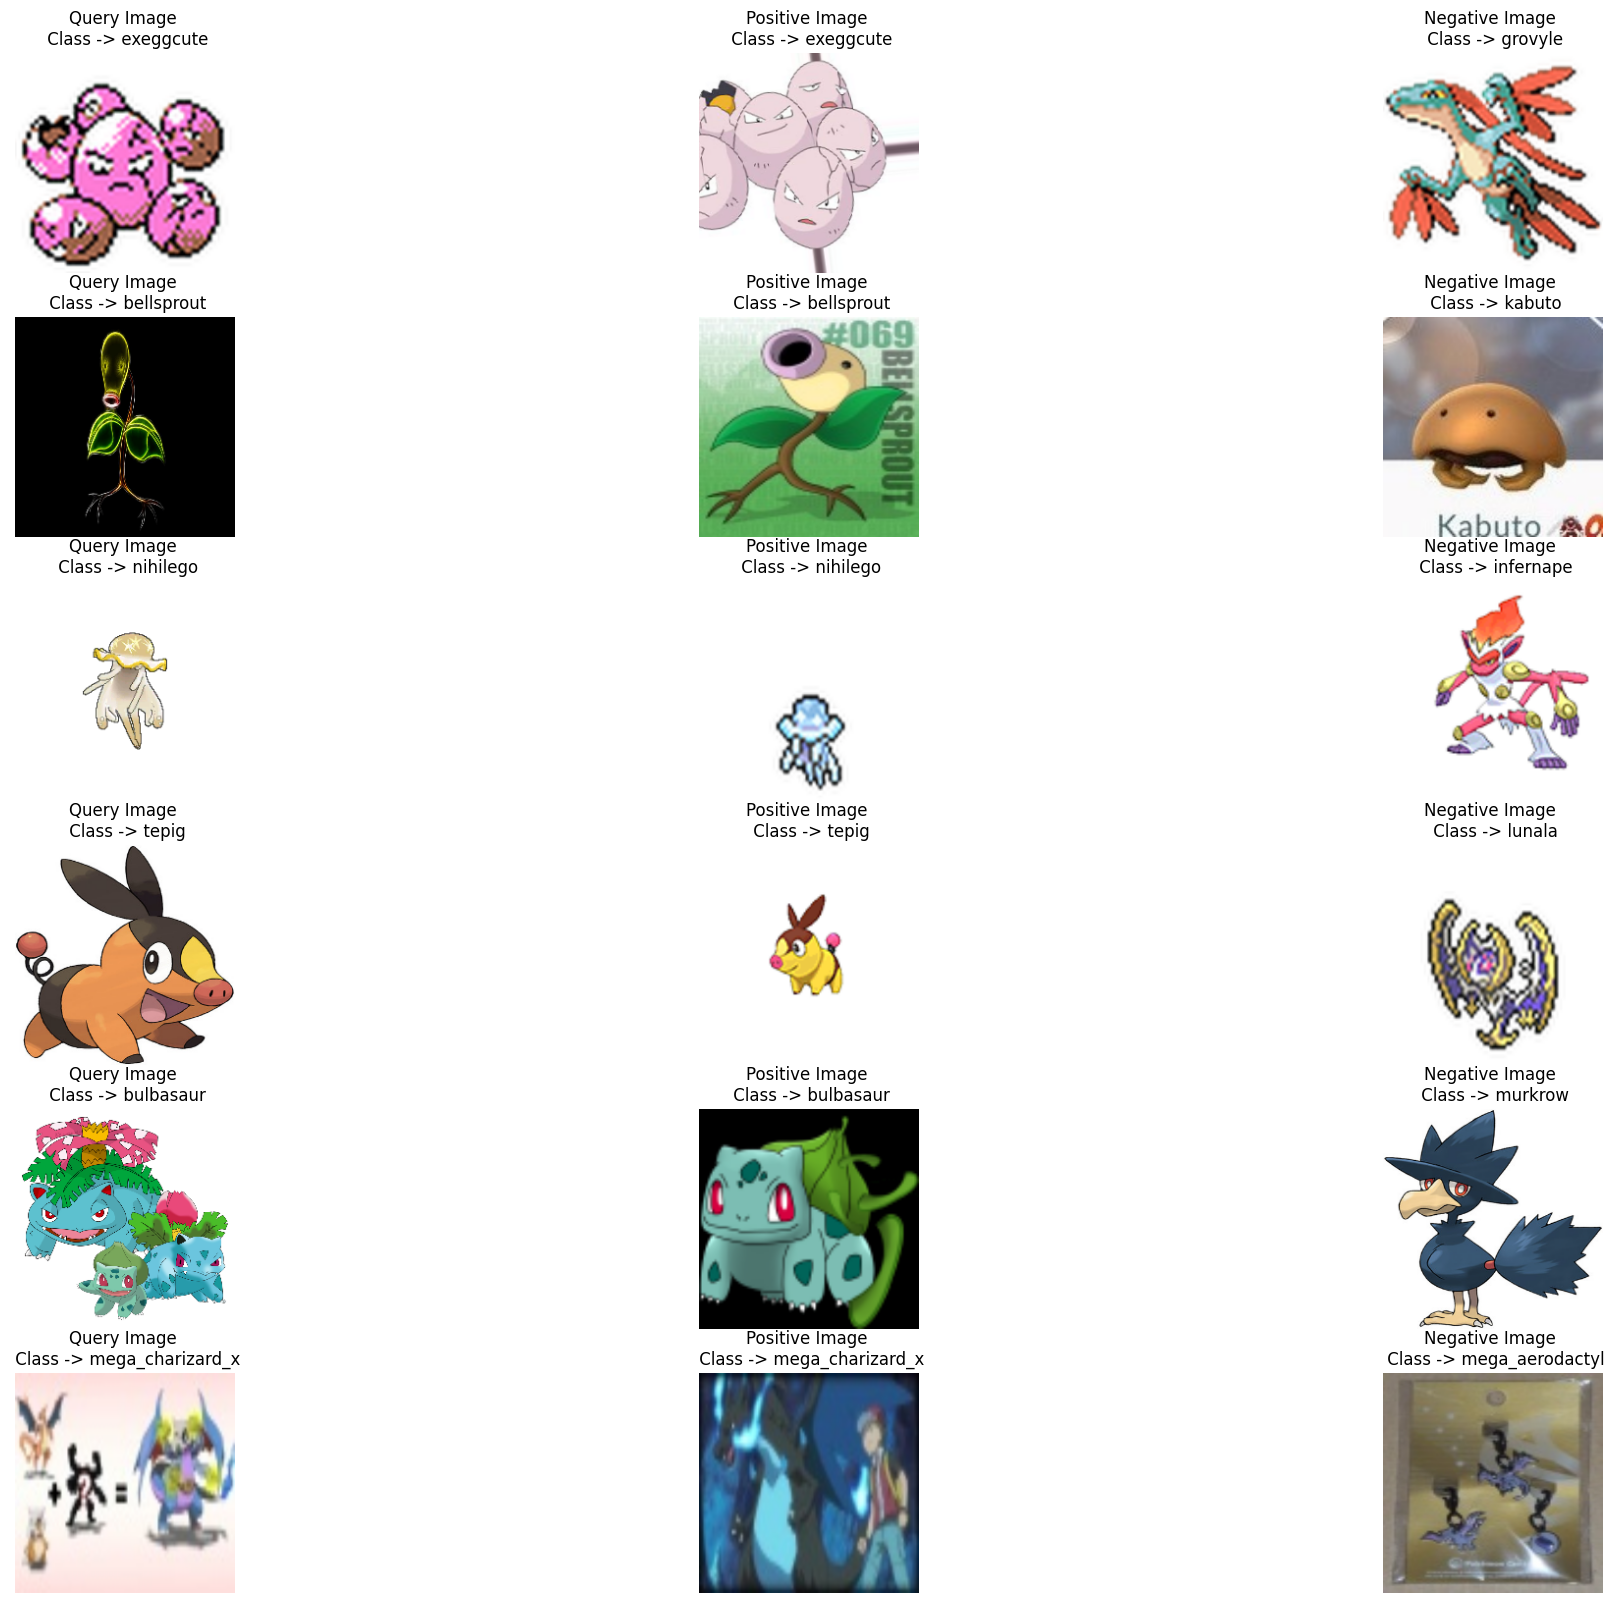

VAL Data Visualization is in process...



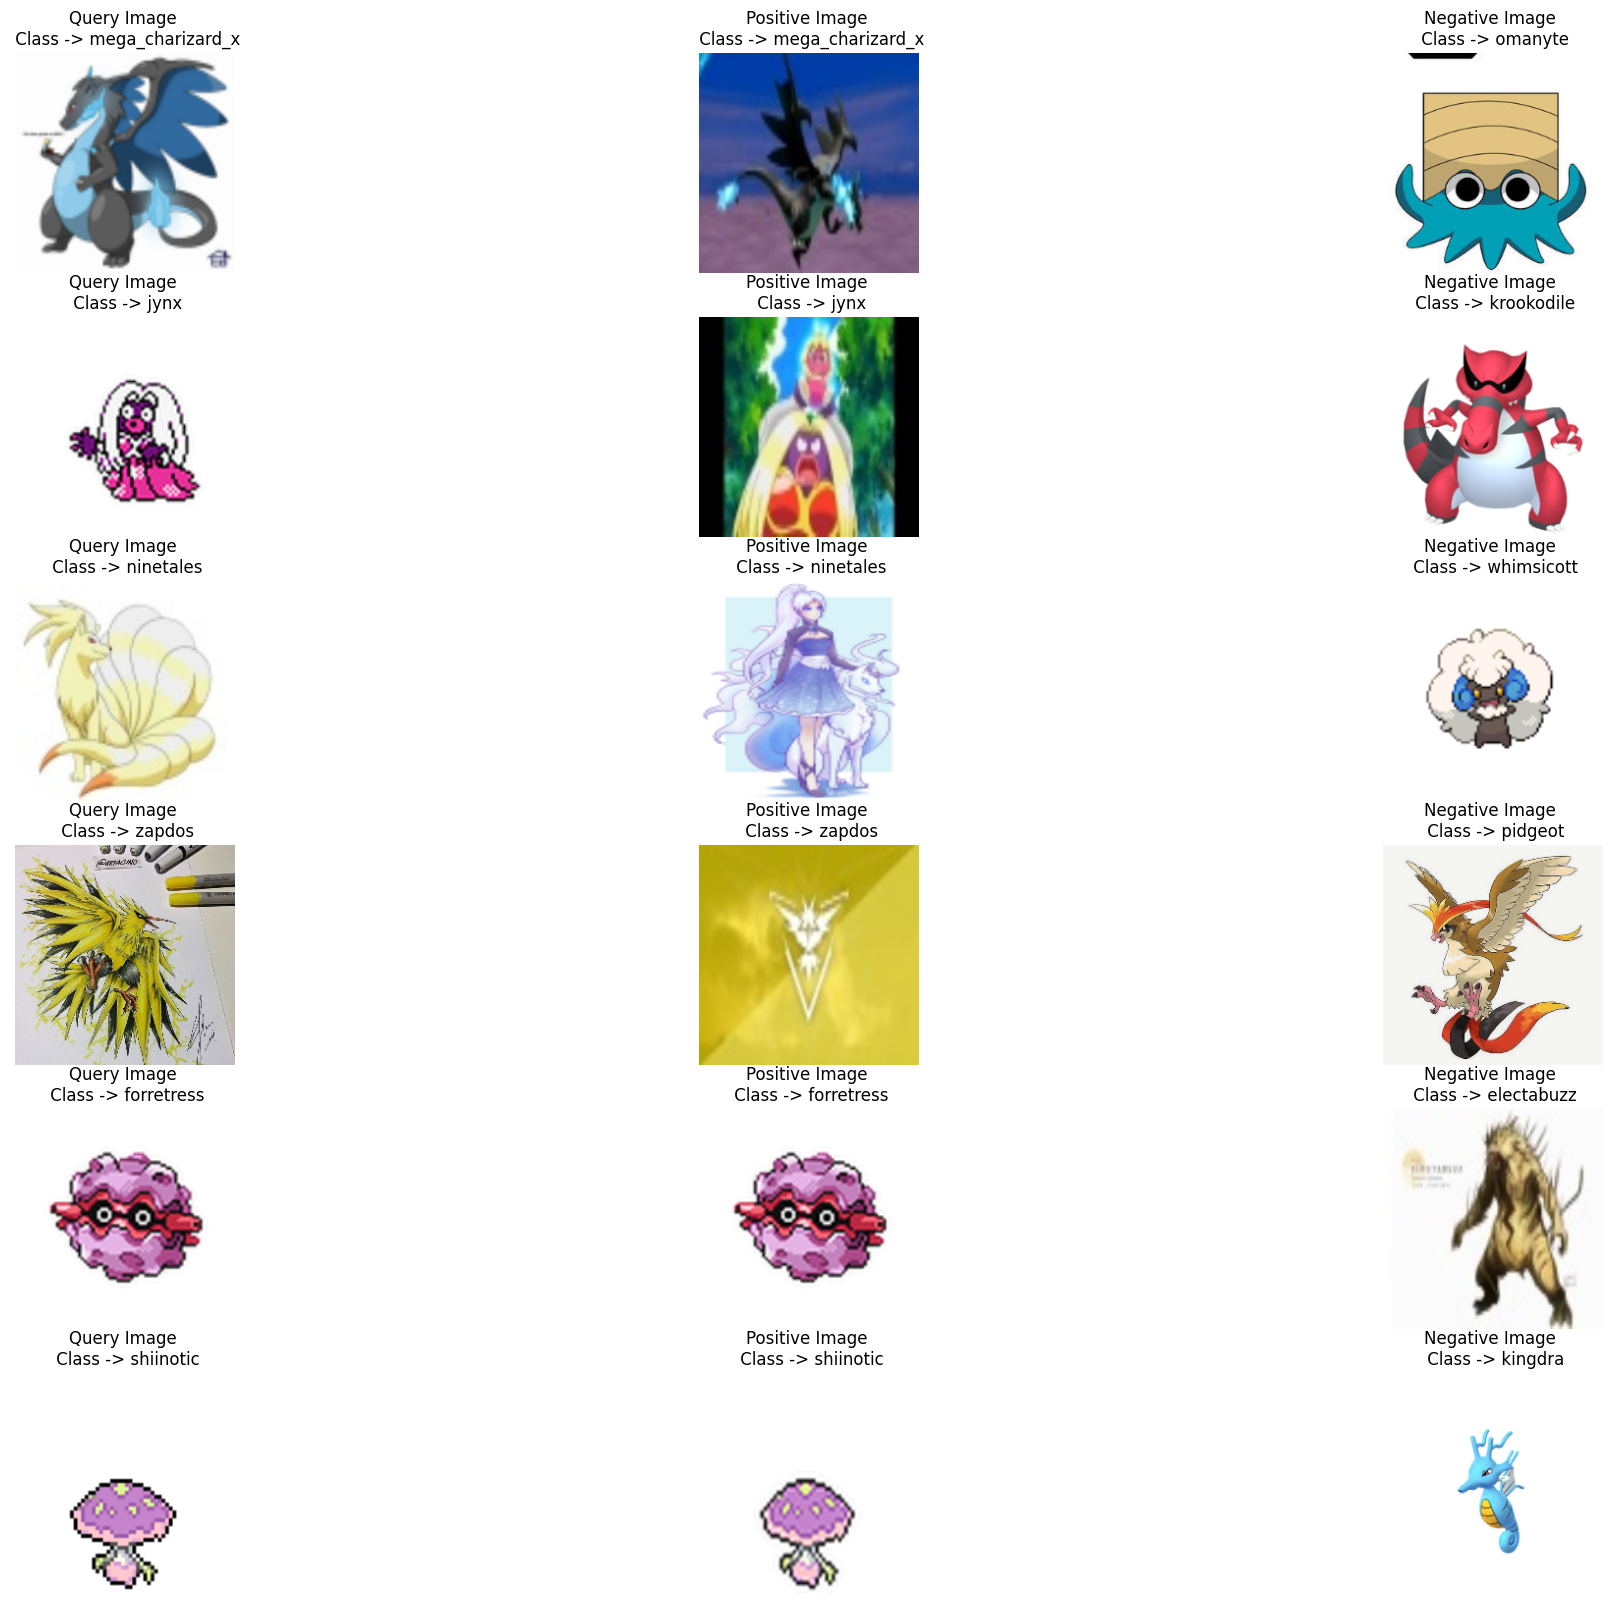

TEST Data Visualization is in process...



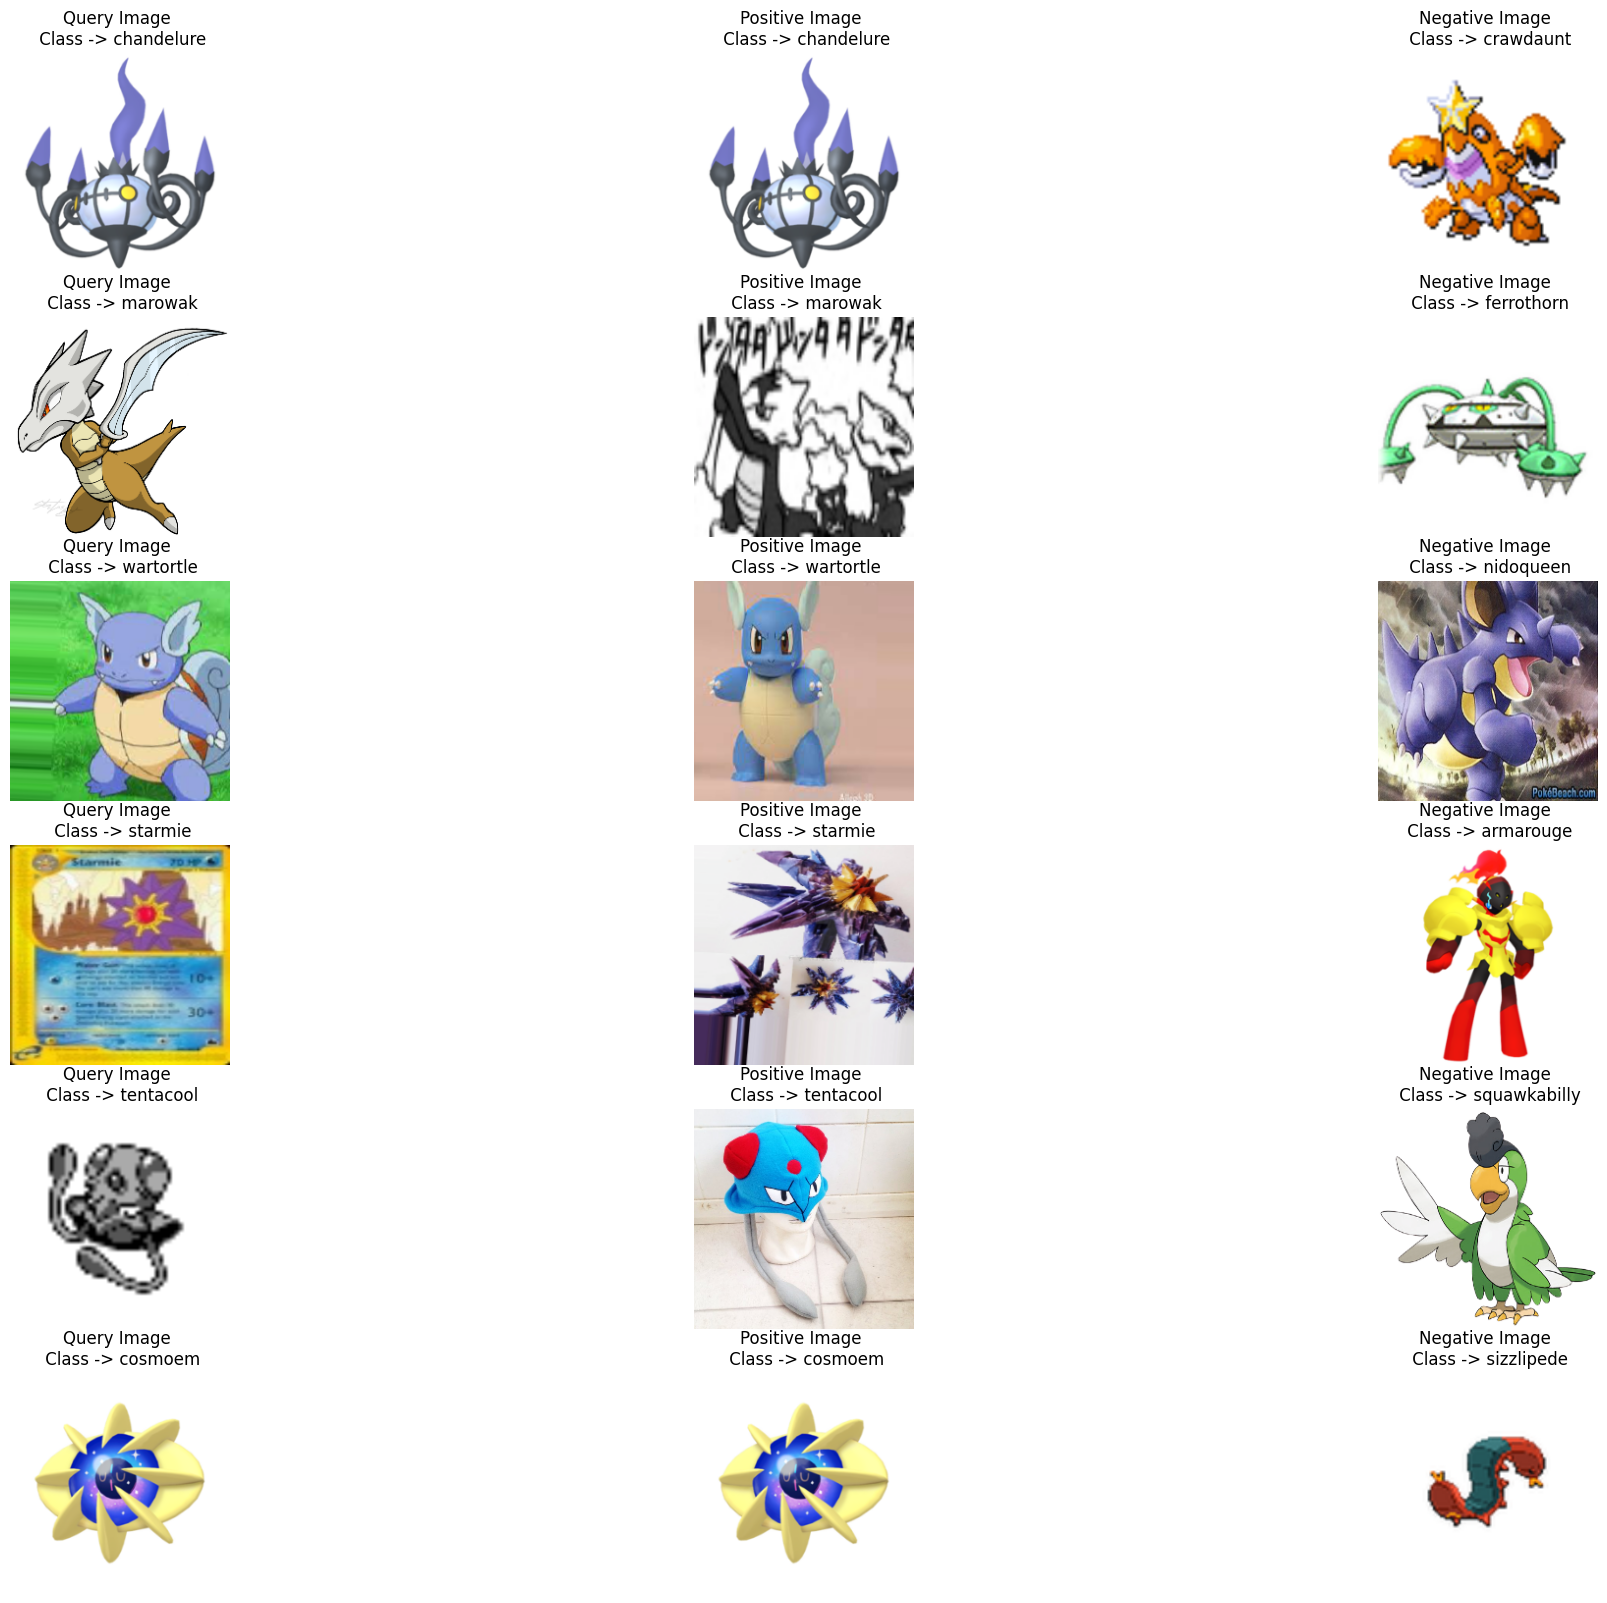

In [22]:
vis.visualization()

In [23]:
import os, timm, torch, datetime
from torchmetrics.classification import MulticlassStatScores, MulticlassF1Score
from tqdm import tqdm
from time import time

class TrainValidation:

    def __init__(self, model_name, tr_dl, val_dl, classes, device, lr, save_dir, 
                 run_name, data_name, epochs, project_name, bs, patience = 5, dev_mode = False):

        self.model_name, self.classes, self.device      = model_name, classes, device
        self.data_name, self.lr, self.save_dir, self.bs = data_name, lr, save_dir, bs
        self.tr_dl, self.val_dl, self.patience, self.dm = tr_dl, val_dl, patience, dev_mode
        self.run_name, self.epochs, self.project_name   = run_name, epochs, project_name
        self.run()
        
    def init_model(self): self.model = timm.create_model(self.model_name, pretrained = True, num_classes = len(self.classes))  
    
    def init_lists(self): self.tr_losses, self.val_losses, self.tr_sens, self.val_senss, self.tr_specs, self.val_specs, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s, self.tr_times, self.vl_times = [], [], [], [], [], [], [], [], [], [], [], []

    def train_setup(self): 
                
        self.best_loss, self.threshold, self.not_improved = float(torch.inf), 0.01, 0
        self.stop_train, self.tr_len, self.val_len        = False, len(self.tr_dl), len(self.val_dl)
        self.cs_lbls = {
            "cos_pos": torch.tensor(1.).unsqueeze(0).to(self.device), 
            "cos_neg": torch.tensor(-1.).unsqueeze(0).to(self.device)
        }
        self.ckpt_path = f"{self.save_dir}/{self.data_name}_{self.run_name}_{self.model_name}_best_model.pth"
        run_name = f"{self.run_name}_{self.model_name}_bs_{self.bs}"
        
        str_time = str(datetime.datetime.now()).split(".")[0]
        
        self.model.to(self.device).eval()
        self.ce_loss_fn   = torch.nn.CrossEntropyLoss() 
        self.cs_loss_fn   = torch.nn.CosineEmbeddingLoss(margin = 0.3) 
        self.optimizer   = torch.optim.Adam(params = self.model.parameters(), lr = self.lr)
        self.f1_score    = MulticlassF1Score(num_classes = len(self.classes), average = "micro").to(self.device) 
        self.stat_scores = MulticlassStatScores(num_classes = len(self.classes), average = "micro").to(self.device)
    
    def makedirs(self, path): os.makedirs(path, exist_ok = True)
    
    def get_fms(self, fms):
        
        """
        s
        This function gets feature map with size (bs, fm_shape, 7, 7)
        applies average pooling and returns feature map with shape (bs, fm_shape).
        
        Parameter:
        
            fm - feature map, tensor.
        
        Output:
        
            fm - reshaped feature map, tensor.
        
        """
        
        pool = torch.nn.AvgPool2d((fms[0].shape[2], fms[0].shape[3]))
        
        return [torch.reshape(pool(fm), (-1, fm.shape[1])) for fm in fms]
    
    def get_logits(self, ims): return [self.model.forward_features(im) for im in ims]

    def get_preds(self, fts): return [self.model.forward_head(ft) for ft in fts]
    
    def get_cs_loss(self, qry_fms, pos_fms, neg_fms): 
        return self.cs_loss_fn(qry_fms, pos_fms, self.cs_lbls["cos_pos"]) + \
               self.cs_loss_fn(qry_fms, neg_fms, self.cs_lbls["cos_neg"])

    def get_ce_loss(self, qry_preds, pos_preds, qry_lbls): return self.ce_loss_fn(qry_preds, qry_lbls) + self.ce_loss_fn(pos_preds, qry_lbls)
    
    def get_preds_loss(self, qry_ims, pos_ims, neg_ims, qry_lbls): 
        
        # Get logits
        qry_logits, pos_logits, neg_logits = self.get_logits([qry_ims, pos_ims, neg_ims])
        qry_preds, pos_preds = self.get_preds([qry_logits, pos_logits])
        
        # Contrastive loss
        qry_fms, pos_fms, neg_fms = self.get_fms([qry_logits, pos_logits, neg_logits])
        cs_loss = self.get_cs_loss(qry_fms, pos_fms, neg_fms)

        # Cross entropy loss
        ce_loss = self.get_ce_loss(qry_preds, pos_preds, qry_lbls)

        # Final loss
        loss = cs_loss + ce_loss
                
        return torch.argmax(qry_preds, dim = 1), loss

    def eval_train_batch(self, preds, gts, loss): 
        
        self.epoch_acc    += (preds == gts).sum().item()
        self.epoch_loss   += loss.item()
        self.epoch_f1     += self.f1_score(preds, gts)
        tp, fp, tn, fn, _  = self.stat_scores(preds, gts)
        self.spec         += tn / (tn + fp)
        self.sens         += tp / (tp + fn)

    def eval_valid_batch(self, preds, gts, loss): 

        self.val_epoch_loss   += loss.item()
        self.val_epoch_acc    += (preds == gts).sum().item()
        self.val_epoch_f1     +=  self.f1_score(preds, gts)
        tp, fp, tn, fn, _      = self.stat_scores(preds, gts)
        self.val_spec         += tn / (tn + fp)
        self.val_sens         += tp / (tp + fn)        
            
    def to_device(self, batch): return batch["qry_im"].to(self.device), batch["pos_im"].to(self.device), batch["neg_im"].to(self.device), batch["qry_gt"].to(self.device)
    
    def train_one_epoch(self, epoch):

        self.model.train()
        self.epoch_loss, self.epoch_acc, self.epoch_f1, self.loss, self.sens, self.spec = 0, 0, 0, 0, 0, 0

        tr_start = time(); 
        for idx, batch in tqdm(enumerate(self.tr_dl)):

            if self.dm:
                if idx == 1: break
            
            qry_ims, pos_ims, neg_ims, qry_im_lbls = self.to_device(batch)

            qry_preds, loss = self.get_preds_loss(qry_ims, pos_ims, neg_ims, qry_im_lbls)
            self.eval_train_batch(qry_preds, qry_im_lbls, loss)
            self.optimizer.zero_grad(); loss.backward(); self.optimizer.step()

        tr_time = time() - tr_start; self.tr_times.append(tr_time)
        tr_loss_to_track = self.epoch_loss / self.tr_len
        tr_sens_to_track = self.sens / self.tr_len
        tr_spec_to_track = self.spec / self.tr_len
        tr_acc_to_track  = self.epoch_acc  / len(self.tr_dl.dataset)
        tr_f1_to_track   = self.epoch_f1   / self.tr_len
        self.tr_losses.append(tr_loss_to_track); self.tr_accs.append(tr_acc_to_track); self.tr_f1s.append(tr_f1_to_track); self.tr_sens.append(tr_sens_to_track); self.tr_specs.append(tr_spec_to_track)
        
        print("\n~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~")
        print(f"\n{epoch + 1}-epoch train process is completed!\n")
        print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch train spec          -> {tr_spec_to_track:.3f}")
        print(f"{epoch + 1}-epoch train sens          -> {tr_sens_to_track:.3f}")
        print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    def eval_one_epoch(self, epoch):

        self.val_epoch_loss, self.val_epoch_acc, self.val_epoch_f1, self.val_sens, self.val_spec = 0, 0, 0, 0, 0
        self.model.eval()
        with torch.no_grad():
            vl_start = time()
            for idx, batch in enumerate(self.val_dl):
                
                if self.dm:
                    if idx == 1: break
                
                qry_ims, pos_ims, neg_ims, qry_im_lbls = self.to_device(batch)

                qry_preds, loss = self.get_preds_loss(qry_ims, pos_ims, neg_ims, qry_im_lbls)
                self.eval_valid_batch(qry_preds, qry_im_lbls, loss)                           

            vl_time = time() - vl_start; self.vl_times.append(vl_time)
            val_loss_to_track = self.val_epoch_loss  / self.val_len
            val_sens_to_track = self.val_sens / self.val_len
            val_spec_to_track = self.val_spec / self.val_len
            val_acc_to_track  = self.val_epoch_acc   / len(self.val_dl.dataset)
            val_f1_to_track   = self.val_epoch_f1    / self.val_len
            self.val_losses.append(val_loss_to_track); self.val_accs.append(val_acc_to_track); self.val_f1s.append(val_f1_to_track); self.val_senss.append(val_sens_to_track); self.val_specs.append(val_spec_to_track)
            
            print(f"\n{epoch + 1}-epoch validation process is completed!\n")
            print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation spec     -> {val_spec_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation sens     -> {val_sens_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

            print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        return val_loss_to_track

    def save_best_model(self): torch.save(self.model.state_dict(), self.ckpt_path); print("Pretrained weights of the model with lowest loss are successfully saved!")
    
    def epoch_summary(self, metric):
        
        if (metric + self.threshold) < self.best_loss:
                
            print(f"\nValidation loss is decreased from {self.best_loss:.5f} to {metric:.5f}")
            print("Saving the best model with the lowest loss value...\n")
            self.best_loss = metric                
            self.save_best_model()            
            
        else:

            self.not_improved += 1
            print(f"\nValidation loss is not significantly decreased from {self.best_loss:.5f}. The current epoch loss is {metric:.5f}.")
            print(f"Validation loss value did not decrease for {self.not_improved} epochs")
            if self.not_improved == self.patience:
                print(f"Stop training since loss value did not decrease for {self.patience} epochs.")
                self.stop_train = True
    
    def train(self):
        
        print("Start training...")
        for epoch in range(self.epochs):
            if self.dm:
                if epoch == 1: break
            self.train_one_epoch(epoch); loss = self.eval_one_epoch(epoch)
            self.epoch_summary(loss)
            if self.stop_train: break
    
    def get_stats(self): return [self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s, self.tr_specs, self.val_specs, self.tr_sens, self.val_senss, self.tr_times, self.vl_times]

    def run(self): self.makedirs(self.save_dir); self.init_lists(); self.init_model(); self.train_setup(); self.train()

In [ ]:
project_name, run_name, model_name   = "kaggle", "triplet", "rexnet_150"
save_dir, data_name, epochs,  = "saved_models", "pokemon", 20
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

results = TrainValidation(model_name = model_name, tr_dl = tr_dl, val_dl = val_dl,
                          classes = classes, device = device, lr = 3e-4, save_dir = save_dir, 
                          data_name = data_name, project_name = project_name, bs = bs, run_name = run_name, 
                          epochs = epochs, patience = 3, dev_mode = False).get_stats()

Training on: cuda
Start training...


4910it [30:58,  2.64it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

1-epoch train process is completed!

1-epoch train loss          -> 2.249
1-epoch train spec          -> 1.000
1-epoch train sens          -> 0.799
1-epoch train accuracy      -> 0.799
1-epoch train f1-score      -> 0.799



1-epoch validation process is completed!

1-epoch validation loss     -> 1.132
1-epoch validation spec     -> 1.000
1-epoch validation sens     -> 0.891
1-epoch validation accuracy -> 0.888
1-epoch validation f1-score -> 0.891

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from inf to 1.13181
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


3045it [18:33,  2.79it/s]

In [27]:
# ===============================
# EXPORT MODEL FOR DEPLOYMENT
# ===============================

import json, torch, os

EXPORT_DIR = "/kaggle/working/export_artifacts"
os.makedirs(EXPORT_DIR, exist_ok=True)

# 1️⃣ Save best model (CPU compatible)
BEST_MODEL = f"{save_dir}/{data_name}_{run_name}_{model_name}_best_model.pth"
EXPORT_MODEL = f"{EXPORT_DIR}/model.pth"

torch.save(
    torch.load(BEST_MODEL, map_location="cpu"),
    EXPORT_MODEL
)

# 2️⃣ Save class map
with open(f"{EXPORT_DIR}/class_map.json", "w") as f:
    json.dump(classes, f)

# 3️⃣ Save inference config
inference_config = {
    "model_name": model_name,
    "img_size": size,
    "mean": mean,
    "std": std,
    "num_classes": len(classes)
}

with open(f"{EXPORT_DIR}/inference_config.json", "w") as f:
    json.dump(inference_config, f, indent=2)

print("✅ Export completed")
print(os.listdir(EXPORT_DIR))

✅ Export completed
['inference_config.json', 'class_map.json', 'model.pth']


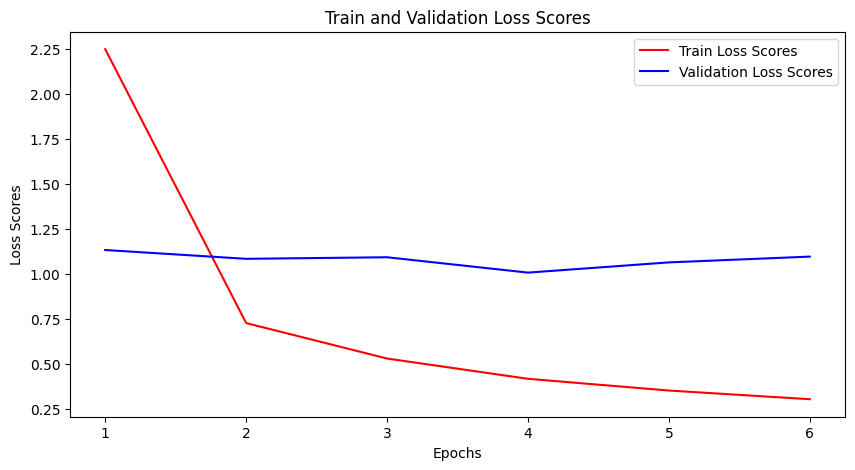

<Figure size 640x480 with 0 Axes>

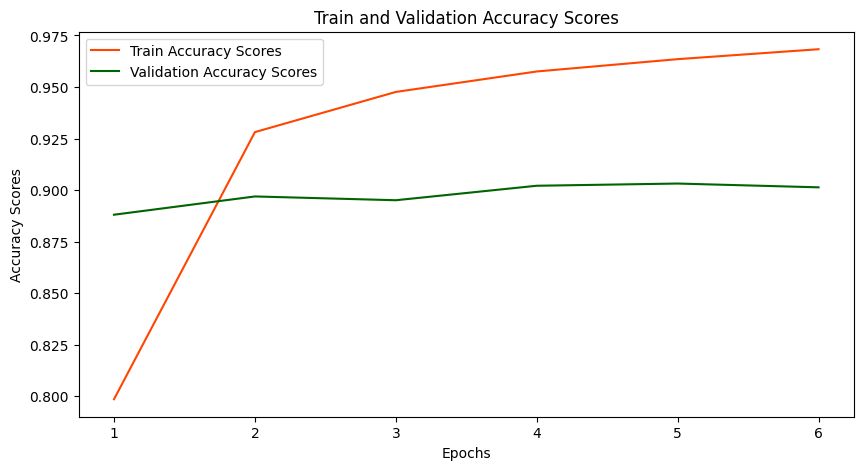

<Figure size 640x480 with 0 Axes>

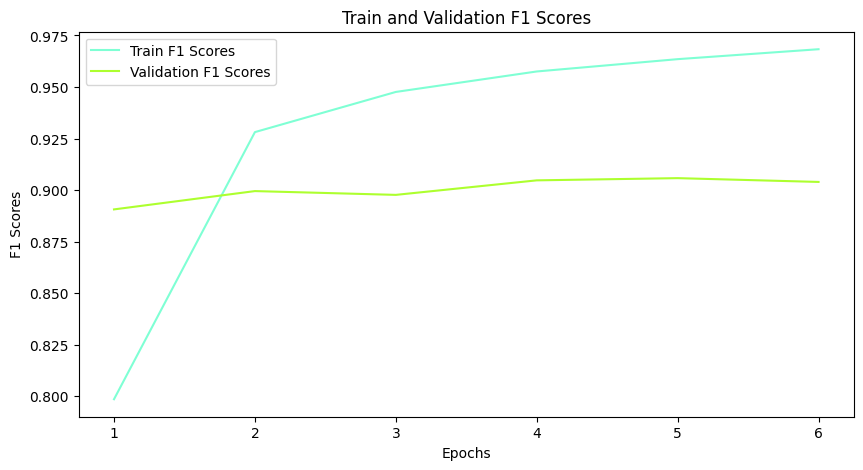

<Figure size 640x480 with 0 Axes>

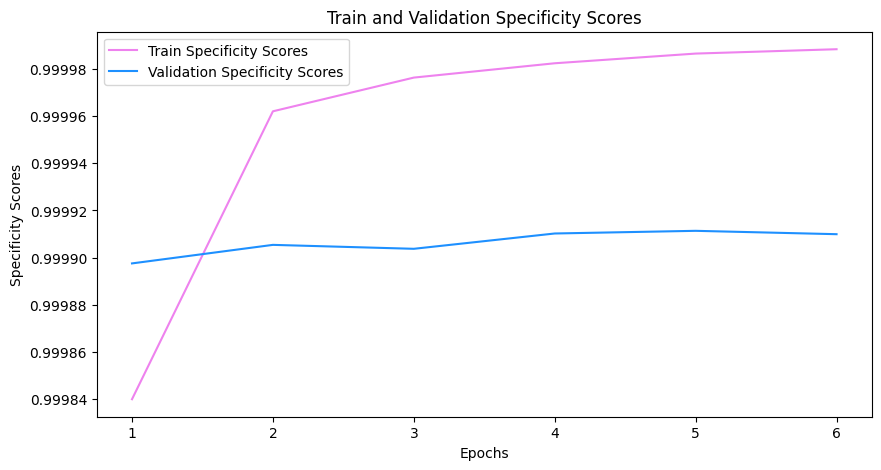

<Figure size 640x480 with 0 Axes>

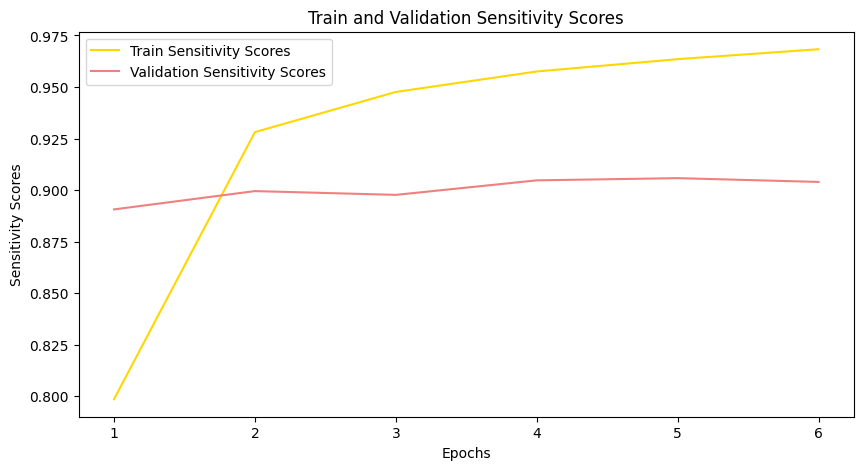

<Figure size 640x480 with 0 Axes>

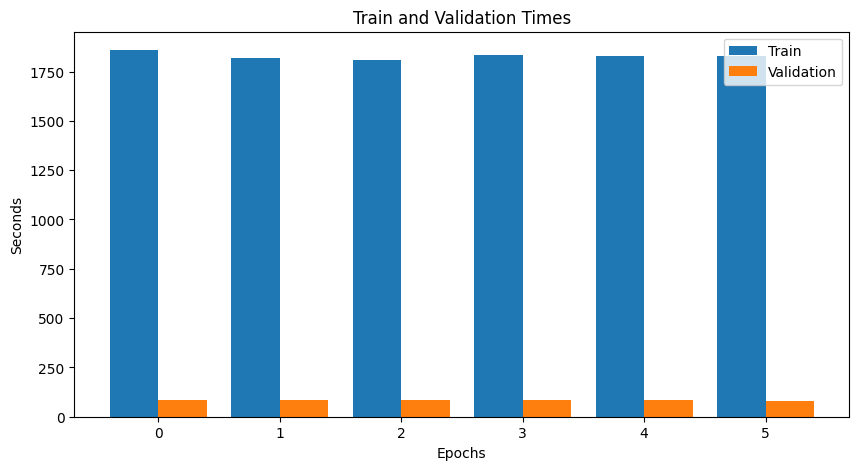

Learning curves can be found in stats

Train times can be found in stats directory under the name times.png



<Figure size 640x480 with 0 Axes>

In [28]:
class TrainProcessSummary:

    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s,
                 val_f1s, tr_specs, val_spec, tr_sens, val_sens, tr_times,
                 vl_times, data_name, save_path = "stats"):
        
        self.makedirs(save_path)
        self.xlbl, self.times_sv_name   = "Epochs", "times.png"
        self.data_name, self.save_path  = data_name, save_path
        self.tr_losses, self.val_losses = tr_losses, val_losses
        self.tr_accs,   self.val_accs   = tr_accs, val_accs
        self.tr_f1s,    self.val_f1s    = tr_f1s, val_f1s
        self.tr_specs,  self.val_spec   = tr_specs, val_spec
        self.tr_sens,   self.val_sens   = tr_sens, val_sens
        self.tr_times,  self.vl_times   = tr_times, vl_times
        self.get_ticks_labels(); self.learning_curves(); self.bar_plot()

        print(f"Learning curves can be found in {self.save_path}\n")
        print(f"Train times can be found in {self.save_path} directory under the name {self.times_sv_name}\n")
    
    def get_ticks_labels(self): self.xtics, self.xlabels = np.arange(len(self.tr_losses)), [i for i in range(1, len(self.tr_losses) + 1)]

    def makedirs(self, path): os.makedirs(path, exist_ok = True)
        
    def create_figure(self):    plt.figure(figsize = (10, 5))

    def move2cpu(self, data):   return [d.cpu() for d in data]

    def plot(self, data1, data2, plot_name, c1, c2):
        
        self.create_figure()
        need2bemoved = ["Sensitivity", "Specificity", "F1"]
        if plot_name in need2bemoved: data1 = self.move2cpu(data1); data2 = self.move2cpu(data2) 
        label = f"{plot_name} Scores"
        plt.plot(data1, label = f"Train {label}", color = c1); plt.plot(data2, label = f"Validation {label}", color = c2)
        plt.xlabel(self.xlbl); plt.ylabel(label); plt.title(f"Train and Validation {label}")
        plt.xticks(ticks = self.xtics, labels = self.xlabels); plt.legend(); plt.show()

    def save(self, save_name):

        sv_name = f"{self.data_name}_{save_name}"
        plt.savefig(f"{self.save_path}/{sv_name}")
        
    def learning_curves(self):
        
        self.plot(self.tr_losses, self.val_losses, "Loss",        "red",        "blue");         self.save("losses.png")
        self.plot(self.tr_accs,   self.val_accs,   "Accuracy",     "orangered",  "darkgreen");   self.save("accs.png")
        self.plot(self.tr_f1s,    self.val_f1s,    "F1",          "aquamarine", "greenyellow");  self.save("f1s.png")
        self.plot(self.tr_specs,  self.val_spec,   "Specificity", "violet",     "dodgerblue");   self.save("specs.png")        
        self.plot(self.tr_sens,   self.val_sens,   "Sensitivity", "gold",       "lightcoral");   self.save("sens.png")
        
    def bar_plot(self):
        
        self.create_figure();               
        
        plt.bar(self.xtics - 0.2, self.tr_times, 0.4, label = "Train") 
        plt.bar(self.xtics + 0.2, self.vl_times, 0.4, label = "Validation") 
        
        plt.xticks(self.xtics);   plt.xlabel(self.xlbl) 
        plt.ylabel("Seconds");    plt.title("Train and Validation Times") 
        plt.legend(); plt.show(); self.save(self.times_sv_name)

TrainProcessSummary(*results, data_name = data_name)